# Train a U-Net for Cell Segmentation
To segment the full cell (cytosol + nucleus) we first train a U-Net to predict the foreground and boundaries of the cells. We will later uses these predictions to segment the cells using a seeded watershed from the nucleus predictions (see previous notebooks).

Here, we will use the pytorch library to train a U-Net using the images and ground-truth data we have downloaded. The goal of this lesson is learning how to use this library for training segmentation models.

Note: we are also working on a notebook that shows how to train a U-Net using only PyTorch in pytorch_train-cell-membrane-segmentation.ipynb. (This is not yet finished.)

In [1]:
# General imports.

import itertools
import json
import os
import sys
import time
from glob import glob

import imageio.v3 as imageio
import matplotlib.pyplot as plt
from matplotlib import colors
import napari
import numpy as np
import skimage
from skimage.metrics import contingency_table, peak_signal_noise_ratio

import torch
from torchvision.transforms import v2

sys.path.append("..")
import utils

/opt/conda/envs/sam/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/sam/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in t

In [2]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

The data is downloaded already.


In [3]:
import gc

model = None
train_loader = None
val_loader = None

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

### 1. Prepare the data for training

In [3]:
# The data has been downloaded and separated into folders for the train, validation and test split already.
# We first create a dictionary with the location of the three different split folders.
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

# And check the content for one of the samples.
# After the print you should see the images (marker, nuclei, serum), labels (cells and nuclei) as well as a json file.
train_sample0 = os.path.join(data_dirs["train"], "gt_image_000")
print(os.listdir(train_sample0))

['gt_image_000_nucleus_image.tif', 'labels.json', 'gt_image_000_marker_image.tif', 'gt_image_000_infected_labels.tif', 'gt_image_000_nucleus_labels.tif', 'gt_image_000_cell_labels.tif', 'gt_image_000_serum_image.tif']


In [14]:
# Here we define the function that cuts out the small images centered around the cells for one image.

# This is a helper function for normalizing an image to the range [0, 1].
# Data normalization is important when training neural networks for image data
# to make sure all the inputs are in the same data range.
def normalize(image):
    image = image.astype("float32")
    # image = (image - np.mean(image)) / np.std(image)
    # Normalised [0,1]
    # image = (image - np.min(image))/np.ptp(image)
    return image


# This is the main function for extracting the small images.
# We give it the path to the folder containing the data for a sample as input.
# Remember that this contains the images, segmentations and classification data
# in individual files for each sample. We have explored some of this data above.
def extract_images_and_labels(sample_folder):

    # We create the filepaths for the image and segmentation data we will load. 
    sample_name = os.path.basename(sample_folder)  # We can derive the sample name from the foldername.

    # serum is the image and cell is the label
    serum_path = os.path.join(sample_folder, f"{sample_name}_serum_image.tif")
    cell_segmentation_path = os.path.join(sample_folder, f"{sample_name}_cell_labels.tif")

    # And load the serum image and the cell segmentation.
    # We normalize the serum image so that the data range is in [0, 1].
    serum = normalize(imageio.imread(serum_path))
    # Note that we must not normalize the segmentation!
    cells = imageio.imread(cell_segmentation_path)
    # convert into binary mask
    # mask = (cells != 0)
    # mask[mask] = 1

    return serum, cells

In [15]:
# This function applies the data extraction function we just defined to all samples
# for a split (training, validation or test) and extracts all the corresponding small images
# and classification labels.
def prepare_split(split):
    # Get all the folders for the samples of this split.
    split_folder = data_dirs[split]
    samples = glob(os.path.join(split_folder, "gt*"))
    # Iterate over all the samples and extract the images and labels from them.
    images, labels = [], []
    for sample in samples:
        sample_image, sample_labels = extract_images_and_labels(sample)
        images.append(sample_image)
        labels.append(sample_labels)
    return images, labels

In [16]:
# Now we apply the functions for the training, validation and test split
# and check how many samples we have for each split.

train_images, train_labels = prepare_split("train")
print("We have", len(train_images), "training samples.")

We have 35 training samples.


In [17]:
val_images, val_labels = prepare_split("val")
print("We have", len(val_images), "validation samples")

We have 5 validation samples


In [18]:
test_images, test_labels = prepare_split("test")
print("We have", len(test_images), "test samples")

We have 9 test samples


In [10]:
# viewer = napari.Viewer()
# # Add the image data: the marker channel (red channel) and nucleus channel (blue channel).
# viewer.add_image(train_images[0], colormap="red", blending="additive")
# viewer.add_image(train_labels[0], colormap="blue", blending="additive")

### 2. Build dataset, dataloader and model

In [19]:
# Import the PyTorch functionality we need.
import torch
from torch.utils.data import Dataset, DataLoader

import tqdm
import torch.nn as nn
import torch.nn.functional as F

# Additional imports for evaluation and image transformations.
from sklearn import metrics
from skimage.transform import resize

In [11]:
# We first check if we have access to a GPU.
# The model training will be much faster if we can use a GPU.
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. The training will be very slow!")
    device = torch.device("cpu")

GPU is available


In [20]:
# In order to use the image data in PyTorch we need to bring all small images to a common size.
# This will enable combining multiple images in one batch and is essential for efficient training (more details below).
# So as a first step we determine the average size of all images in our training and validation set.
shapes = np.stack([np.array(image.shape) for image in (train_images + val_images)])
mean_shape = np.mean(shapes, axis=0)
print("Mean image shape:", mean_shape)
print(train_images[0].dtype)

Mean image shape: [1000.5 1024. ]
float32


In [21]:
# To provide the data for training we need to create a PyTorch Dataset.
# Datasets provide a single example (= small image + label) for training.
# They can also be used to process the data further. Here, we resize the images
# to the common shape within the dataset.

# You can find more information on datasets here:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# To create a dataset for our task we create a class that inherits
# from the PyTorch dataset.
class CustomDataset(Dataset):
    # Here we define the data for creating the dataset:
    # The small images for this dataset, the labels and the size for reshaping the images.
    def __init__(self, images, labels, crop_size, transform=None, mask_transform=None):
        self.images = images
        self.labels = labels
        self.crop_size = crop_size
        self.transform = transform
        self.mask_transform = mask_transform

    # A dataset needs a __len__ method that returns how many samples are in the dataset.
    # Here, the number of samples corresponds to the number of small images.
    def __len__(self):
        return len(self.images)

    # The __getitem__ method returns the image data and labels for a given sample index.
    def __getitem__(self, index):
        # Load the image data and label for this sample index.
        image = self.images[index]
        mask = self.labels[index]

        # crop the images, so that we can fit them into memory
        crop_shape = self.crop_size
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            # bring it to common shape
            image = resize(image, shape, preserve_range=True)
            mask = resize(mask, shape, preserve_range=True)
            # Random crop same excerpt from image and mask
            i, j, h, w = v2.RandomCrop.get_params(
                torch.tensor(image), output_size=self.crop_size
            )
            image = v2.functional.crop(torch.tensor(image), i, j, h, w)
            mask = v2.functional.crop(torch.tensor(mask), i, j, h, w)
        
        # make sure to add the channel dimension to the image
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]      
            
        # apply transform if available
        if self.transform:
            image = self.transform(image)           
        if self.mask_transform:
            mask = self.mask_transform(mask)   

        return image, mask

In [44]:
# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer, scheduler=None):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if scheduler is not None:
        if metric is not None:
            scheduler.step(np.mean(metric_list))  # Pass the mean of the metric values to the scheduler
        else:
            scheduler.step(np.mean(loss_list))  # Alternatively, pass the mean of the loss values to the scheduler

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None

# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs, scheduler
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in tqdm.trange(n_epochs):
        epoch_train_loss, epoch_train_acc = train_epoch(model, train_loader, loss, metric, optimizer, scheduler)
        epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss, metric)
        
        # save the loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
    
    return train_losses, train_accs, val_losses, val_accs


# plot the metrics
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    #sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    #sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [22]:
# a function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap

In [17]:
# # UNet ex4
# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super().__init__()
#         in_features = [in_channels, 64, 128, 256]
#         out_features = [64, 128, 256, 512]
#         self.encoders = nn.ModuleList([
#             self.encoder_block(in_feats, out_feats, pool=level>0)
#             for level, (in_feats, out_feats) in enumerate(zip(in_features, out_features))
#         ])
#         self.base = self.encoder_block(512, 1024, pool=True)
        
#         in_features = [1024, 512, 256, 128]
#         out_features = [512, 256, 128, 64]
#         self.decoders = nn.ModuleList([
#             self.decoder_block(in_feats, out_feats)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.upsamplers = nn.ModuleList([
#             nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.out_conv = nn.Conv2d(out_features[-1], out_channels, 1)
        
#     def encoder_block(self, in_feats, out_feats, pool):
#         layers = [nn.MaxPool2d(2)] if pool else []
#         layers.extend([
#             nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         ])
#         return nn.Sequential(*layers)
    
#     def decoder_block(self, in_feats, out_feats):
#         return nn.Sequential(*[
#             nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         ])
    
    
#     def forward(self, x):
#         from_encoder = []
#         for encoder in self.encoders:
#             x = encoder(x)
#             from_encoder.append(x)
#         x = self.base(x)
#         from_encoder = from_encoder[::-1]
#         for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
#             x = decoder(torch.cat([
#                 from_enc, upsampler(x)
#             ], dim=1))
#         x = self.out_conv(x)
#         return x

In [18]:
# # UNet2d from torch_em
# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super().__init__()
#         in_features = [in_channels, 64, 128, 256]
#         out_features = [64, 128, 256, 512]
#         self.encoders = nn.ModuleList([
#             self.encoder_block(in_feats, out_feats, pool=True)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.base = self.encoder_block(512, 1024, pool=True)
        
#         in_features = [1024, 512, 256, 128]
#         out_features = [512, 256, 128, 64]
#         self.decoders = nn.ModuleList([
#             self.decoder_block(in_feats, out_feats)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.upsamplers = nn.ModuleList([
#             nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.out_conv = nn.Conv2d(out_features[-1], out_channels, 1)
        
#     def encoder_block(self, in_feats, out_feats, pool):
#         layers = [
#             nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         ]
#         if pool:
#             layers.insert(0, nn.MaxPool2d(2))
#         return nn.Sequential(*layers)
    
#     def decoder_block(self, in_feats, out_feats):
#         return nn.Sequential(*[
#             nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         ])
    
    
#     def forward(self, x):
#         from_encoder = []
#         for encoder in self.encoders:
#             x = encoder(x)
#             from_encoder.append(x)
#         x = self.base(x)
#         from_encoder = from_encoder[::-1]
#         for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
#             x = decoder(torch.cat([
#                 from_enc, upsampler(x)
#             ], dim=1))
#         x = self.out_conv(x)
#         x = torch.sigmoid(x)
#         return x


# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         # Encoder
#         self.encoder1 = DoubleConv(in_channels, 64)
#         self.encoder2 = DoubleConv(64, 128)
#         self.encoder3 = DoubleConv(128, 256)
#         self.encoder4 = DoubleConv(256, 512)
        
#         # Decoder
#         self.decoder4 = DoubleConv(512, 256)
#         self.decoder3 = DoubleConv(256, 128)
#         self.decoder2 = DoubleConv(128, 64)
#         self.decoder1 = DoubleConv(64, out_channels)  
        
#         # Upsampling layers
#         self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
#     def forward(self, x):
#         # Encoder path
#         x1 = self.encoder1(x)
#         x2 = self.encoder2(x1)
#         x3 = self.encoder3(x2)
#         x4 = self.encoder4(x3)
        
#         # Decoder path
#         x = self.decoder4(x4)
#         x = self.upsample1(x)
#         x = torch.cat([x, x3], dim=1)
#         x = self.decoder3(x)
#         x = self.upsample2(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.decoder2(x)
#         x = self.upsample3(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.decoder1(x)
        
#         return x

    
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)
# Example usage:
# Create a UNet with 1 input channel and 1 output channel
# model = UNet(in_channels=1, out_channels=1)
# print(model)

# # Example usage with input and output tensors of shape [1, 256, 256]
# x = torch.randn(1, 1, 256, 256)

# output = model(x)
# print("Output shape:", output.shape)


In [19]:
# # # UNet ex4 parameters/2
# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super().__init__()
#         in_features = [in_channels, 32, 64, 128]
#         out_features = [32, 64, 128, 256]
#         self.encoders = nn.ModuleList([
#             self.encoder_block(in_feats, out_feats, pool=level>0)
#             for level, (in_feats, out_feats) in enumerate(zip(in_features, out_features))
#         ])
#         self.base = self.encoder_block(256, 512, pool=True)
        
#         in_features = [512, 256, 128, 64]
#         out_features = [256, 128, 64, 32]
#         self.decoders = nn.ModuleList([
#             self.decoder_block(in_feats, out_feats)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.upsamplers = nn.ModuleList([
#             nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
#             for in_feats, out_feats in zip(in_features, out_features)
#         ])
#         self.out_conv = nn.Conv2d(out_features[-1], out_channels, 1)
#         self.last_activation = nn.Sigmoid()
        
#     def encoder_block(self, in_feats, out_feats, pool):
#         layers = [nn.MaxPool2d(2)] if pool else []
#         layers.extend([
#             nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         ])
#         return nn.Sequential(*layers)
    
#     def decoder_block(self, in_feats, out_feats):
#         return nn.Sequential(*[
#             nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#         ])
    
#     def forward(self, x):
#         from_encoder = []
#         for encoder in self.encoders:
#             x = encoder(x)
#             from_encoder.append(x)
#         x = self.base(x)
#         from_encoder = from_encoder[::-1]
#         for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
#             x = decoder(torch.cat([
#                 from_enc, upsampler(x)
#             ], dim=1))
#         x = self.out_conv(x)
#         return x

# # Example usage:
# # Create a UNet with 1 input channel and 1 output channel
# model = UNet(in_channels=1, out_channels=1)
# print(model)

# # Example usage with input and output tensors of shape [1, 256, 256]
# x = torch.randn(1, 1, 256, 256)

# output = model(x)
# print("Output shape:", output.shape)

In [39]:
# CustomUNet2d
class UNet(nn.Module):
    def conv_block(self, in_feats, out_feats):
        return nn.Sequential(
            nn.InstanceNorm2d(in_feats),
            nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(out_feats),
            nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def __init__(self, initial_features=32, in_channels=1, out_channels=1):
        super().__init__()
        
        in_features = [in_channels, initial_features, initial_features * 2, initial_features * 4]
        out_features = [initial_features, initial_features * 2, initial_features * 4, initial_features * 8]
        
        self.encoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats) for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.poolers = [nn.MaxPool2d(2)] * len(in_features)
        self.base = self.conv_block(initial_features * 8, initial_features * 16)

        in_features = [initial_features * 16, initial_features * 8, initial_features * 4, initial_features * 2]
        out_features = [initial_features * 8, initial_features * 4, initial_features * 2, initial_features]
        self.decoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.upsamplers = nn.ModuleList([
            nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.out_conv = nn.Conv2d(out_features[-1], out_channels, 1)
        # TODO make sigmoid optional
        self.last_activation = nn.Sigmoid()

    def forward(self, x):
        from_encoder = []
        for encoder, pooler in zip(self.encoders, self.poolers):
            x = encoder(x)
            from_encoder.append(x)
            x = pooler(x)
        x = self.base(x)
        from_encoder = from_encoder[::-1]
        for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
            x = decoder(torch.cat([
                from_enc, upsampler(x)
            ], dim=1))
        x = self.out_conv(x)
        x = self.last_activation(x)
        return x

In [35]:
im, _ = next(iter(train_loader))

In [40]:
net = UNet(32)
# TODO apply the u-net to one image

In [22]:
# yet another UNet

# def double_convolution(in_channels, out_channels):
#     conv_op = nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True)
#     )
#     return conv_op

# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()

#         self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Contracting path
#         self.down_convolution_1 = double_convolution(in_channels, 64)
#         self.down_convolution_2 = double_convolution(64, 128)
#         self.down_convolution_3 = double_convolution(128, 256)
#         self.down_convolution_4 = double_convolution(256, 512)
#         self.down_convolution_5 = double_convolution(512, 1024)

#         # Expanding path
#         self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.up_convolution_1 = double_convolution(1024, 512)
#         self.up_transpose_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.up_convolution_2 = double_convolution(512, 256)
#         self.up_transpose_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.up_convolution_3 = double_convolution(256, 128)
#         self.up_transpose_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.up_convolution_4 = double_convolution(128, 64)

#         self.out = nn.Conv2d(64, out_channels, kernel_size=1)

#     def forward(self, x):
#         down_1 = self.down_convolution_1(x)
#         down_2 = self.down_convolution_2(self.max_pool2d(down_1))
#         down_3 = self.down_convolution_3(self.max_pool2d(down_2))
#         down_4 = self.down_convolution_4(self.max_pool2d(down_3))
#         down_5 = self.down_convolution_5(self.max_pool2d(down_4))

#         up_1 = self.up_transpose_1(down_5)
#         x = self.up_convolution_1(torch.cat([down_4, up_1], dim=1))

#         up_2 = self.up_transpose_2(x)
#         x = self.up_convolution_2(torch.cat([down_3, up_2], dim=1))

#         up_3 = self.up_transpose_3(x)
#         x = self.up_convolution_3(torch.cat([down_2, up_3], dim=1))

#         up_4 = self.up_transpose_4(x)
#         x = self.up_convolution_4(torch.cat([down_1, up_4], dim=1))

#         out = self.out(x)
#         return out

# # Example usage:
# # Create a UNet with 1 input channel and 1 output channel
# model = UNet(in_channels=1, out_channels=1)
# print(model)

# # Example usage with input and output tensors of shape [1, 256, 256]
# x = torch.randn(1, 1, 256, 256)
# output = model(x)
# print("Output shape:", output.shape)


# Train with boundary channel
To avoid merges of touching cells, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation funtion. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [24]:
# the issue should now be resolved. Let's try it out.
from scipy.ndimage import label
try:
    from skimage.segmentation import find_boundaries, watershed
except ImportError:
    fix_scipy_imports()
    from skimage.segmentation import find_boundaries, watershed

In [24]:
# # 0 for backgorund, 1 for foreground (= cells) and 2 for boundary (boundary pixel between cells and background or between 2 cells)
# def label_transform(mask):
#     fg_target = (mask > 0)
#     bd_target = find_boundaries(mask, mode="thick")
#     # target = np.zeros(mask.shape, dtype="int64")
#     # target[fg_target] = 0
#     # target[bd_target] = 1
#     return bd_target[None].astype("float64") # target
#     # return target

In [25]:
# # visualize the new label transform and make sure it's correct
# counter = 0
# for im, target in train_dataset:
#     if counter >= 2:
#         break
#     fig, ax = plt.subplots(1, 2, figsize=(10, 6))
#     ax[0].axis("off")
#     ax[0].imshow(im[0].squeeze(), cmap="gray")
#     ax[1].axis("off")
#     ax[1].imshow(target.squeeze())
#     plt.show()
#     counter += 1

### Implement and Use: Dice Loss Function
CrossEntropyLoss and BinaryCrossEntropyLoss do not return the desired results. We call the data "unbalanced" because the label we want to predict is disproportionately small in relation to the background (in particular the boundary channel). Therefore, it is beneficial to use a loss function that is robust against class imbalance:
In this part of the exercise we will use the Dice coefficient as loss.


Note that we do not need to predict a channel for background when using the dice coefficient as a loss (unlike with Cross Entropy).

In [26]:
# # disproportional
# img, mask = train_dataset[0]
# num_zeros = np.count_nonzero(mask == 0)
# num_ones = np.count_nonzero(mask == 1)
# print("Number of zeros:", num_zeros, "Number of ones:", num_ones, "ones/zeros:", num_ones/num_zeros)

In [58]:
def label_transform(mask):
    mask = np.array(mask)
    fg_target = (mask > 0).astype("float32")
    bd_target = find_boundaries(mask, mode="thick").astype("float32")
    # return bd_target
    return np.stack([fg_target, bd_target])

In [60]:
crop_shape = (512, 512) # (512,512)  # (128,128)# 
batch_size = 1

# create datasets
train_dataset = CustomDataset(train_images, train_labels, crop_size=crop_shape, mask_transform=label_transform)
val_dataset = CustomDataset(val_images, val_labels, crop_size=crop_shape, mask_transform=label_transform)
# test_dataset = CustomDataset(test_images, test_labels, crop_size=crop_shape, mask_transform=label_transform)

# create loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [29]:
# # Define your dataset with new transform
# train_dataset = CustomDataset(train_images, train_labels, crop_size=crop_shape, mask_transform=label_transform)
# val_dataset = CustomDataset(val_images, train_labels, crop_size=crop_shape, mask_transform=label_transform)

In [61]:
im, target = next(iter(train_dataset))
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(target)
napari.run()

In [62]:
def flatten_samples(input_):
    # Get number of channels
    num_channels = input_.size(1)
    # Permute the channel axis to first
    permute_axes = list(range(input_.dim()))
    permute_axes[0], permute_axes[1] = permute_axes[1], permute_axes[0]
    # For input shape (say) NCHW, this should have the shape CNHW
    permuted = input_.permute(*permute_axes).contiguous()
    # Now flatten out all but the first axis and return
    flattened = permuted.view(num_channels, -1)
    return flattened


def dice_score(input_, target, eps=1e-7):
    assert input_.shape == target.shape, f"{input_.shape}, {target.shape}"
    # Flatten input and target to have the shape (C, N),
    # where N is the number of samples
    input_ = flatten_samples(torch.sigmoid(input_))
    target = flatten_samples(target)
    # Compute numerator and denominator (by summing over samples and
    # leaving the channels intact)
    numerator = (input_ * target).sum(-1)
    denominator = (input_ * input_).sum(-1) + (target * target).sum(-1)
    channelwise_score = 2 * (numerator / denominator.clamp(min=eps))
    # take the average score over the channels
    score = channelwise_score.mean() # sum() is the torch_em default # mean in ex4
    #score = channelwise_score
    #print(score.shape)
    return score

In [63]:
class DiceLoss(nn.Module):
    def forward(self, input_, target):
        return 1. - dice_score(input_, target)

In [33]:
# override the forward function to add a sigmoid activation
# sigmoid activation is needed in combination with the new loss function: dice loss

# note: using dice loss with normalized images -> output predictions vanishes
# class MyUNet(UNet):
#     def forward(self, x):
#         # call parent's forward method
#         x = super().forward(x)
#         x = self.last_activation(x)
#         return x


In [64]:
model = UNet(initial_features=32, out_channels=2)
model.to(device)
loss = DiceLoss()
loss.to(device)

DiceLoss()

In [42]:
device

device(type='cuda')

100%|██████████| 20/20 [01:39<00:00,  4.99s/it]


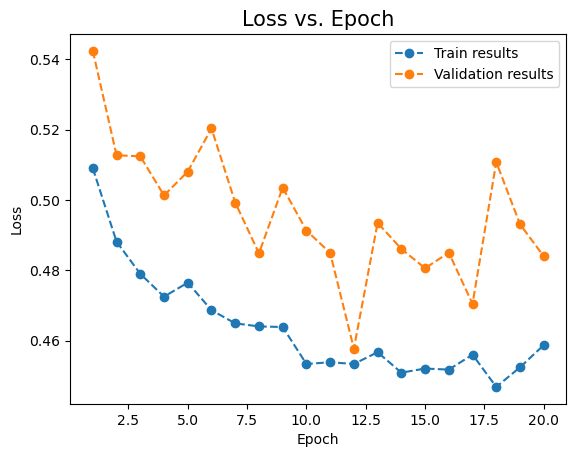

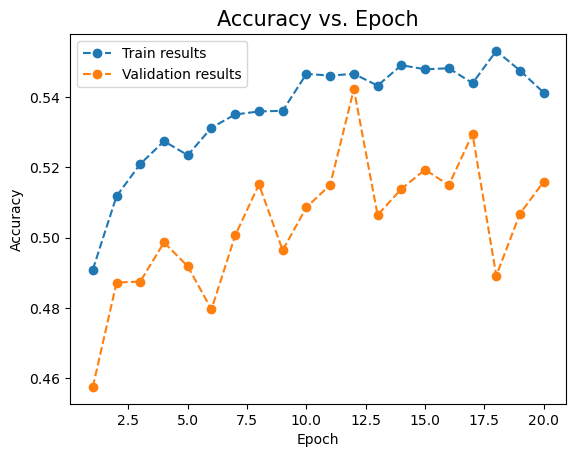

In [65]:
# run the training again
n_epochs = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # default LR -3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
metric = dice_score
train_losses, train_accs, val_losses, val_accs = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs, scheduler)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Accuracy vs. Epoch', 'Accuracy', train_accs, val_accs)

/tmp/ipykernel_9725/603180582.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred).cpu().numpy().squeeze()


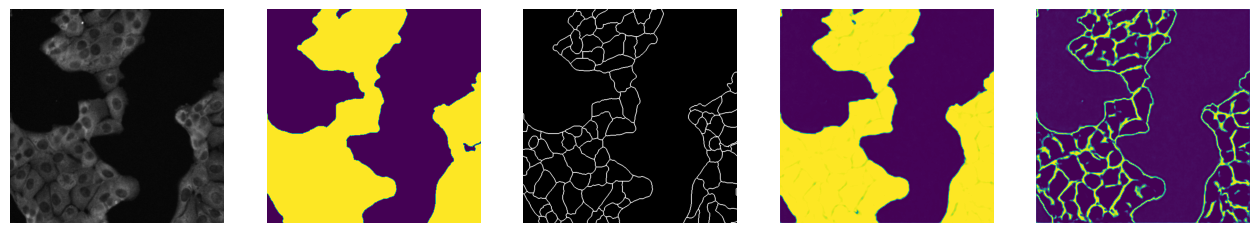

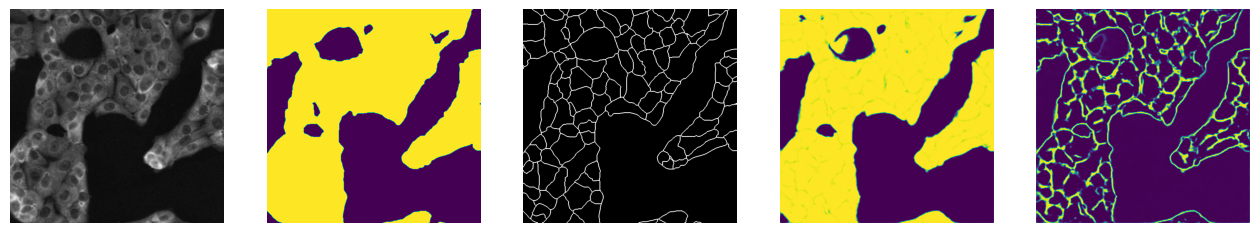

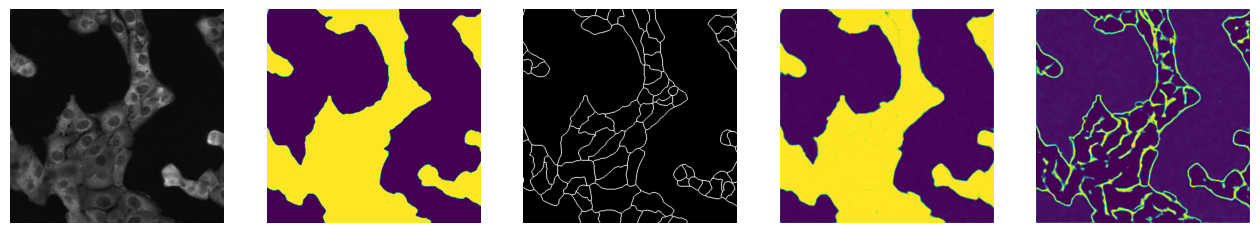

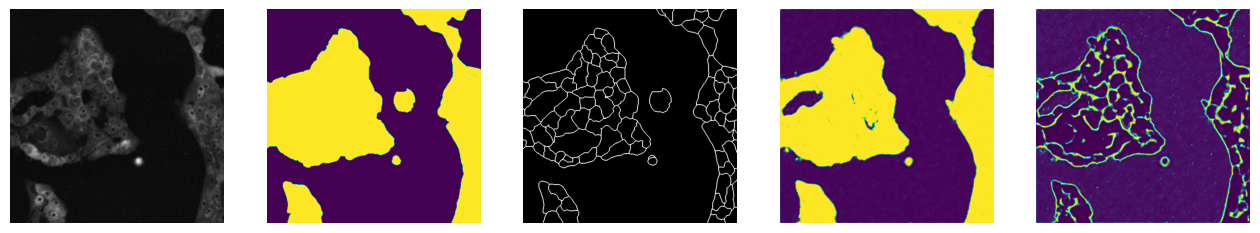

In [68]:
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in val_loader:
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(im.to(device))
        #pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        pred = torch.tensor(pred).cpu().numpy().squeeze()
        #print( pred.shape)
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        fig, ax = plt.subplots(1, 5, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im.squeeze(), cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask[0, 0], cmap="viridis") # ,cmap=get_random_colors(mask[0]), interpolation="nearest"
        ax[2].axis("off")
        ax[2].imshow(mask[0, 1], cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(pred[0]) # , cmap=get_random_colors(pred[0]), interpolation="nearest"
        ax[4].axis("off")
        ax[4].imshow(pred[1]) # , cmap=get_random_colors(pred[1]), interpolation="nearest"
        # print( pred[0].mean())
        # print( pred[1].mean())
        # print("pred0:", np.min(pred[0]), np.mean(pred[0]),np.max(pred[0]),"\t", "pred1:", np.min(pred[1]),np.mean(pred[1]),np.max(pred[1]))
        plt.show()
        counter += 1

In [49]:
print(type(im))

<class 'numpy.ndarray'>
